In [7]:
import pandas as pd
import numpy as np

In [8]:
file = open('beerguide.txt', 'rt')
lines = file.readlines()
file.close()

lines[:] = [element for element in lines if element != '\n' ]
lines = [i.split('\n', 1)[0] for i in lines]

In [9]:
#Get the list of all 79 beers
a = lines.index('Table of Contents')
b = lines.index('Specialty Beer')

beerlist = lines[a:b+1]
beerlist[:] = [element for element in beerlist if '\ue004' not in element][1:]

In [10]:
#Replace irregular characters produced from converting pdf
word_replace_dict = {'\xa0': ' ', 
                     '\xad': '-',
                     '\x0c':'',
                    '\ue000':'B',
                    '\ue001':'E',
                    '\ue002':'S',
                    '\ue004':'s',
                    '\ue006':'y'}
beerdes = lines[b+1:]

for k,v in word_replace_dict.items():
    beerdes = [word.replace(k,v) for word in beerdes]

In [11]:
#List all the features we want to include in the model
feature = ['IBU', 'BU:GU', 'CO2 Volumes', 'Apparent Attenuation', 'Alcohol', 
             'Collar of Foam (Head Retention)', 'Collar of Foam (Texture)',
            'Hop Aroma/Flavor', 'Hop bitterness','Malt Aroma/Flavor',
            'Palate Body', 'Palate Carbonation', 'Palate Length/Finish', 'Esters']

In [12]:
#Create a dictionary that lists values for all the features
def beer_info(beer,character):
    l = []
    for i in range(len(character)):
        if character[i] == 'Alcohol':
            l.append([beer [beer.index('Alcohol')+1]][0])
        
        else:
            a = [element for element in beer if character[i] in element]
            if a:
                l.append(a[0].split(character[i],1)[1])
            else:
                l.append(np.nan)
               
    return l

In [13]:
# %debug
beer_dic = {}

for j in range(len(beerlist)):
    if j == len(beerlist)-1:
        b = beerdes[beerdes.index(beerlist[j]):]
    else:
        b = beerdes[beerdes.index(beerlist[j]):beerdes.index(beerlist[j+1])]
    beer_dic[beerlist[j]] = beer_info(beer = b, character = feature)

In [14]:
#Convert dictionary to dataframe
data = pd.DataFrame(beer_dic, index= feature).transpose()
data.fillna('None', inplace = True)

#Fix a few lost values from converting pdf
data.loc['Bohemian-Style Pilsener'].IBU = '30 - 45'
data.loc['Bohemian-Style Pilsener']['Hop bitterness'] = 'medium'

In [15]:
df = data.copy()

In [113]:
# for i in df.columns:
#     print(i, '\n', df[i].unique())

In [16]:
###Feature Engineering


#Clean IBU, BU:GU, Apparent Attenuation
#Use mid-point of the range
#If varies, use mid_point of the entire range. And Create another column that flags it if its value was varies.

df['IBU'] = df['IBU'].str.strip()
df['IBU_varies'] = [1 if 'varies' in df['IBU'][w].lower() else 0 for w in range(len(df))]
# df_IBU_most_freq = df['IBU'].loc[df['IBU'] != 'Varies'].value_counts().idxmax()
df['IBU'].loc[df['IBU'] == 'Varies'] = '50 - 50'
df['IBU'] = (df.IBU.str.split(' ').str[0].astype(float) + df.IBU.str.split(' ').str[2].astype(float))/2


df['BU:GU'] = df['BU:GU'].str.strip()
df['BU:GU_varies'] = [1 if 'varies' in df['BU:GU'][w].lower() else 0 for w in range(len(df))]
# df_BUGU_most_freq = df['BU:GU'].loc[df['BU:GU'] != 'Varies'].value_counts().idxmax()
df['BU:GU'].loc[df['BU:GU'] == 'Varies'] = '0.5 - 0.5'
df['BU:GU'] = (df['BU:GU'].str.split(' ').str[0].astype(float) + df['BU:GU'].str.split(' ').str[2].astype(float))/2

df['Apparent Attenuation'] = df['Apparent Attenuation'].str.strip()
df['Apparent Attenuation_varies'] = [1 if 'varies' in df['Apparent Attenuation'][w].lower() else 0 for w in range(len(df))]
# df_att_most_freq = df['Apparent Attenuation'].loc[df['Apparent Attenuation'] != 'Varies'].value_counts().idxmax()
df['Apparent Attenuation'].loc[df['Apparent Attenuation'] == 'Varies'] = '50 - 50'
df['Apparent Attenuation'] = (df['Apparent Attenuation'].str.split(' ').str[0].astype(float) + df['Apparent Attenuation'].str.split(' ').str[2].astype(float))/2

#Clean CO2 Volumes
#Use mid-point of the range
#If varies, use mid_point of the entire range. And Create another column that flags it if its value was varies.
#If approximately, use the approximation value

df['CO2 Volumes'] = df['CO2 Volumes'].str.strip()
df['CO2 Volumes_varies'] = [1 if 'varies' in df['CO2 Volumes'][w].lower() else 0 for w in range(len(df))]
# df_CO2_most_freq = df['CO2 Volumes'].loc[df['CO2 Volumes'] != 'Varies'].value_counts().idxmax()
df['CO2 Volumes'].loc[df['CO2 Volumes'] == 'Varies'] = '2.5 - 2.5'
df['CO2 Volumes'] = df['CO2 Volumes'].str.replace(r'\b approximately', '')

CO2_1st_all = df['CO2 Volumes'].str.split(' ').str[0].astype(float)
CO2_3rd_all = df['CO2 Volumes'].str.split(' ').str[2].astype(float)
CO2_1st_no_nan = df['CO2 Volumes'].loc[CO2_3rd_all.isnull() == False].str.split(' ').str[0].astype(float)
CO2_3rd_no_nan = df['CO2 Volumes'].loc[CO2_3rd_all.isnull() == False].str.split(' ').str[2].astype(float)

df['CO2 Volumes'].loc[CO2_3rd_all.isnull() == True] = CO2_1st_all
df['CO2 Volumes'].loc[CO2_3rd_all.isnull() == False] = (CO2_1st_no_nan + CO2_3rd_no_nan) / 2

/Users/AndreaWenYiWang/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
#Alcohol: Not detectable, Mild, Noticeable, Harsh/Hot， Varies
#Create binary columns for each value
i = 'Alcohol'
c = {'Not_Det':['not detectable'], 'Mild':['mild'], 'Noticeable':['noticeable'], 'Varies':['varies'], 
     'Harsh':['hot', 'harsh']}

for k,v in c.items():
    df['Alcohol_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]
df.drop(i,1,inplace = True)

#Collar of Foam (Head Retention): Poor, Moderate, Good, Varies
#Create binary columns for each value
i = 'Collar of Foam (Head Retention)'
c = {'Poor':['poor'], 'Mod':['moderate'], 'Good':['good'], 'Varies':['varies']}

for k,v in c.items():
    df['Foam_Head_Ret_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]
df.drop(i,1,inplace = True)


#Collar of Foam (Texture): Thin, Interrupted, Foamy, Fluffy, Rocky, Mousse-like, Varies
#Create binary columns for each value
i = 'Collar of Foam (Texture)'
c = {'Thin':['thin'], 'Intrpt':['interrupted'],'Foamy':['foam'], 'Fluffy':['fluf'], 'Rocky':['rock'],
    'Mousse':['mous'], 'Varies':['varies']}

for k,v in c.items():
    df['Foam_Texture_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]
df.drop(i,1,inplace = True)

#Palate Body: Drying, Soft, Moderate, Mouth-Coating, Sticky, Varies
#Create binary columns for each value
i = 'Palate Body'
c = {'Drying':['dry'], 'Soft':['soft'], 'Mod':['moderate'], 'Mthct':['mouth-coating'], 'Sticky':['stick'], 
     'Varies':['varies']}

for k,v in c.items():
    df['Pt_Body_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]
df.drop(i,1,inplace = True)

#Palate Carbonation: Very Low, Low, Medium, High
#Create binary columns for each value
i = 'Palate Carbonation'
c = {'VLow':['very low'], 'Low':['low'], 'Med':['medium'], 'High':['high']}

for k,v in c.items():
    df['Pt_Carb_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]

df.drop(i,1,inplace = True)


#Palate Length/Finish: Short, Medium, Long, Varies
#Create binary columns for each value

i = 'Palate Length/Finish'
c = {'Short':['short'], 'Med':['medium'], 'Long':['long'], 'Varies':['varies']}

for k,v in c.items():
    df['Pt_Len_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]

df.drop(i,1,inplace = True)    


    
#Hop bitterness: very low (minimal), low, medium, high
#Create binary columns for each value
i = 'Hop bitterness'

c = {'minimal':['none,','absent', 'not perceived', 'very low', 'minimal', 'not perceived'], 
     'low':['low'], 'medium':['medium', 'moderate'], 'high':['high','strong']}

for k,v in c.items():
    df['Hopbit_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]

df.drop(i,1,inplace = True)
#Hop aroma: Citrus, Fruity, Floral, Fresh, Herbal, woody, chocolate; very low (minimal), low, medium, high

i = 'Hop Aroma/Flavor'
c = {'minimal':['none,','absent', 'not perceived', 'very low', 'minimal'], 
     'low':['low'], 'medium':['medium', 'moderate'], 'high':['high','strong'],
    'flower':['flower','floral'], 'citrus':['citrus'], 'wood':['wood', 'pine', 'rust'], 
     'varies':['varies', 'are evident over a full range from low to high', "may be evident at the brewer's discretion"]}

for k,v in c.items():
    df['Hop_AF_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]
df.drop(i,1,inplace = True) 

#Malt Aroma Flavor 
i = 'Malt Aroma/Flavor'
c = {'minimal':['none,','absent', 'not perceived', 'very low', 'minimal'], 
     'low':['low'], 'medium':['medium', 'moderate'], 'high':['high','strong', 'intense'],
    'varies':['varies'], 
     'wheat':['wheat', 'bread', 'toast', 'biscuit', 'grain'], 
     'sweet': ['sweet', 'choco', 'cocoa', 'caram','toffee', 'candy', 'honey'], 
     'dry':['dry']}

for k,v in c.items():
    df['MaltAF_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))] 
df.drop(i,1,inplace = True)


#Esters: Fruit(Citrus, Orange, Lemon, Banana, Cherry, Pear, Apple, Grape, Plum, Prune), Smoke/Smoky 
    #Date, Fig, Pine, Raisin
#Create binary columns for each value
i = 'Esters'
c = {'minimal':['none,','absent', 'not perceived', 'very low', 'minimal', 'not common to style'], 
     'low':['low'], 'medium':['medium', 'moderate'], 'high':['high','strong', 'intense'],
    'varies':['varies'],
     'Fruit':['fruit', 'citrus','orange','lemon','banana','cherry','pear','apple','grape','plum','prune', 'fig', 'raisin'],
    'Smoke':['smok'], 'Pine':['pine']}

for k,v in c.items():
    df['Esters' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]

df.drop(i,1,inplace = True)

In [18]:
for i in df.columns:
    print(i, '\n', df[i].unique())

IBU 
 [ 35.   24.   80.   60.   50.   16.   42.5  70.   65.   10.   40.   47.5
  22.5  37.5  27.5  11.5  18.   25.   29.   32.5  13.5   4.5  20.   30.
  12.5  49.   17.   26.   38.5  22.   20.5  21.5  23.   50.5  82.5]
BU:GU 
 [ 0.7    0.485  0.75   0.91   0.5    0.685  0.325  0.88   0.47   0.77   0.71
  0.22   0.84   0.45   0.61   0.48   0.36   0.365  0.215  0.335  0.415
  0.305  0.505  0.39   0.285  0.15   0.74   0.79   0.43   0.455  0.275
  0.765  0.44   0.55   0.84   0.62   0.63   0.605  0.355  0.405  0.785
  0.24   0.65   0.54   0.335  0.265  0.47   0.935  0.81   0.615  0.38   0.4
  0.58   0.51   0.49 ]
CO2 Volumes 
 [2.25 2.5 2.45 2.75 3.5 4.0 1.25 3.25 3.75 1.75 3.9 2.0]
Apparent Attenuation 
 [ 72.     75.     77.5    50.     72.5    86.     78.     73.5    77.915
  77.     75.5    78.5    73.     81.5    79.5    76.5    79.     91.     83.
  84.5    83.5    66.     74.5    78.14   76.     74.     82.5    71.5    71.
  68.5    70.5    69.5    82.   ]
IBU_varies 
 [0 1]
BU:GU_va

Clustering method: average
Cophenetic Correlation Coefficient: 0.824


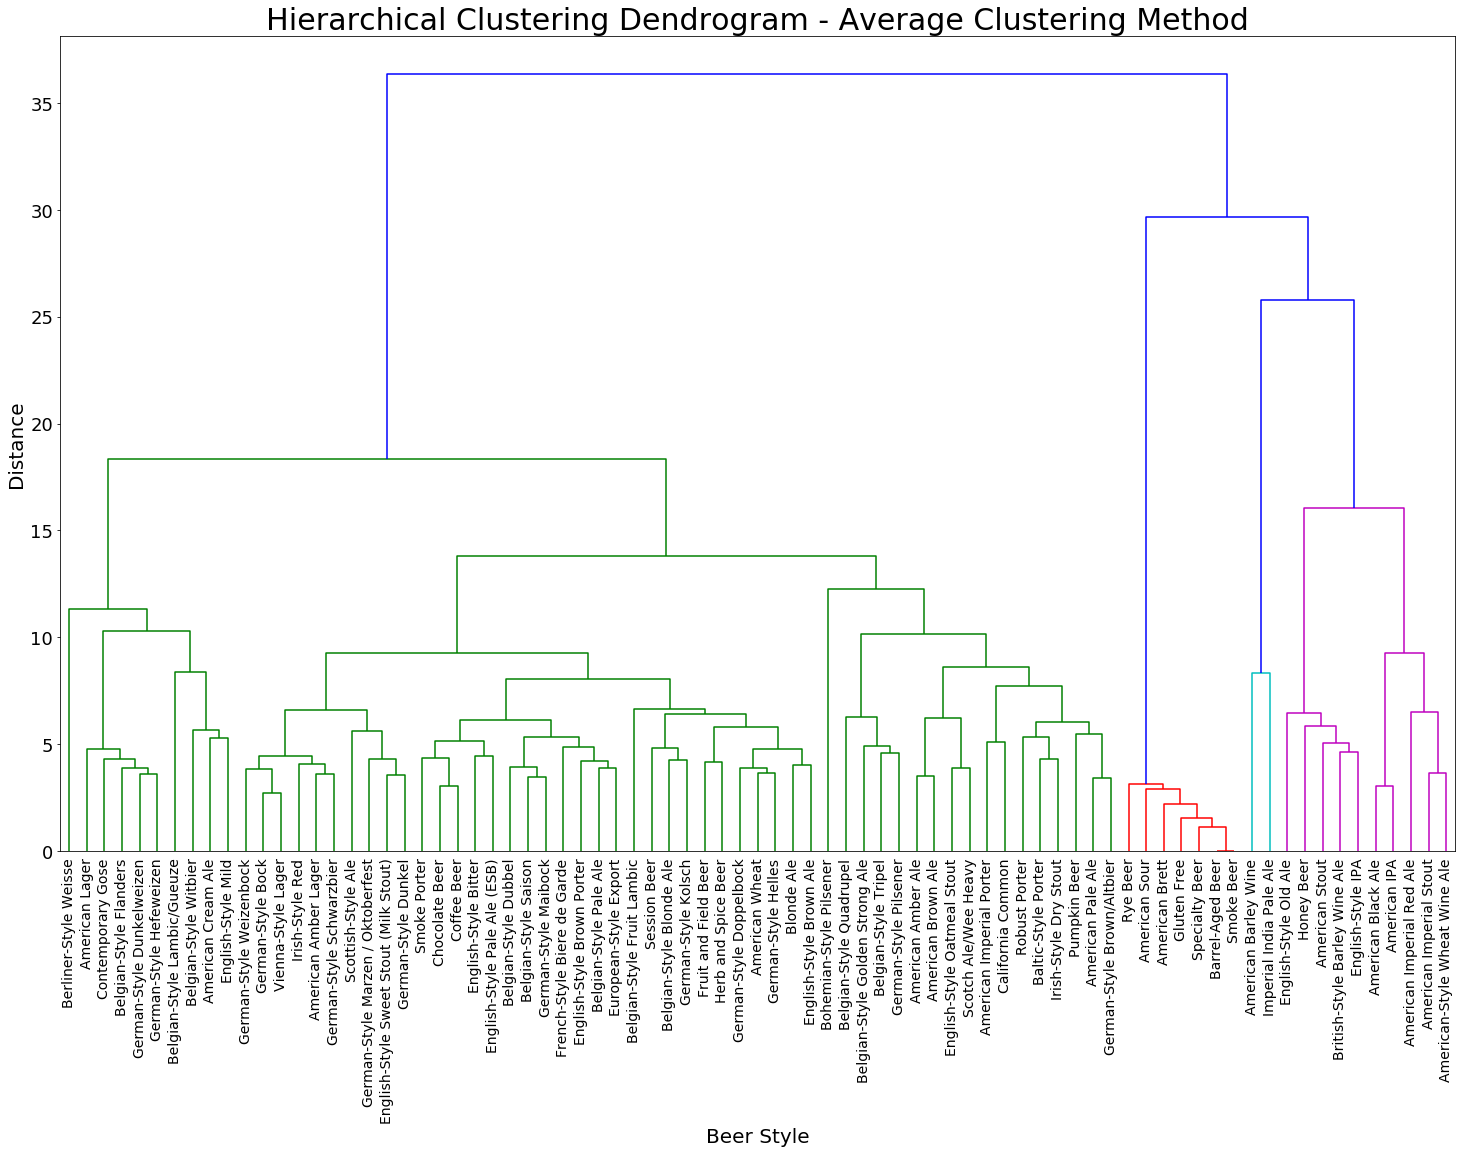

Clustering method: centroid
Cophenetic Correlation Coefficient: 0.823


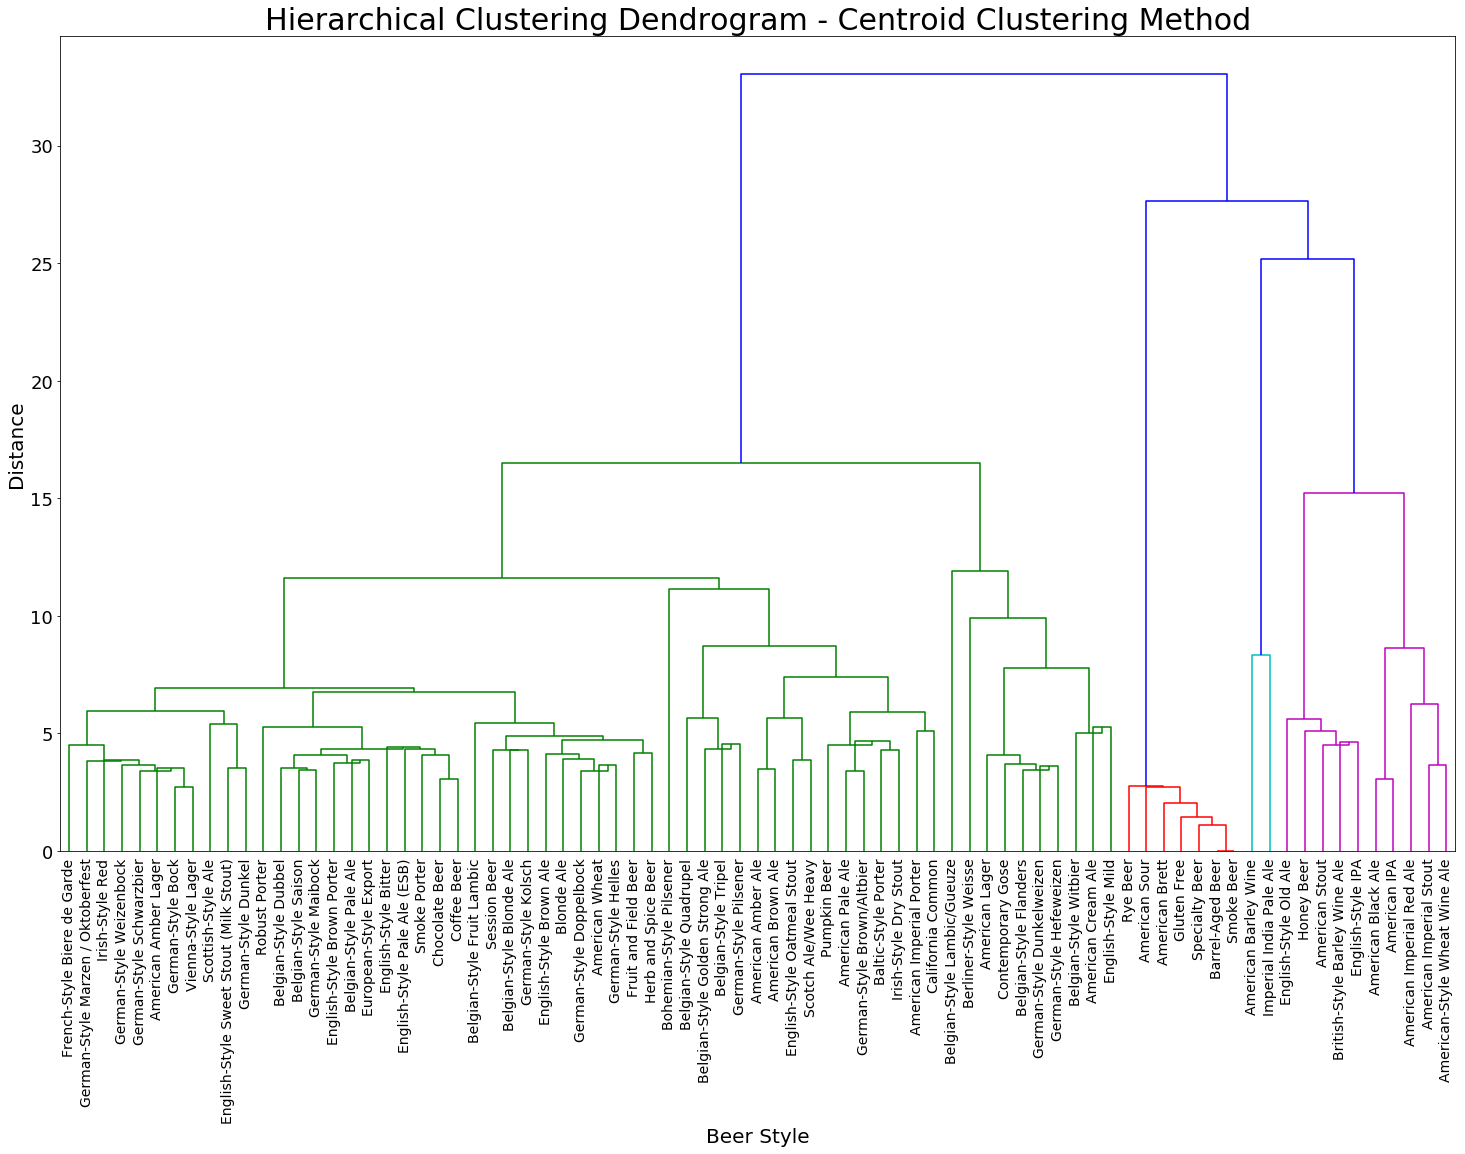

Clustering method: ward
Cophenetic Correlation Coefficient: 0.691


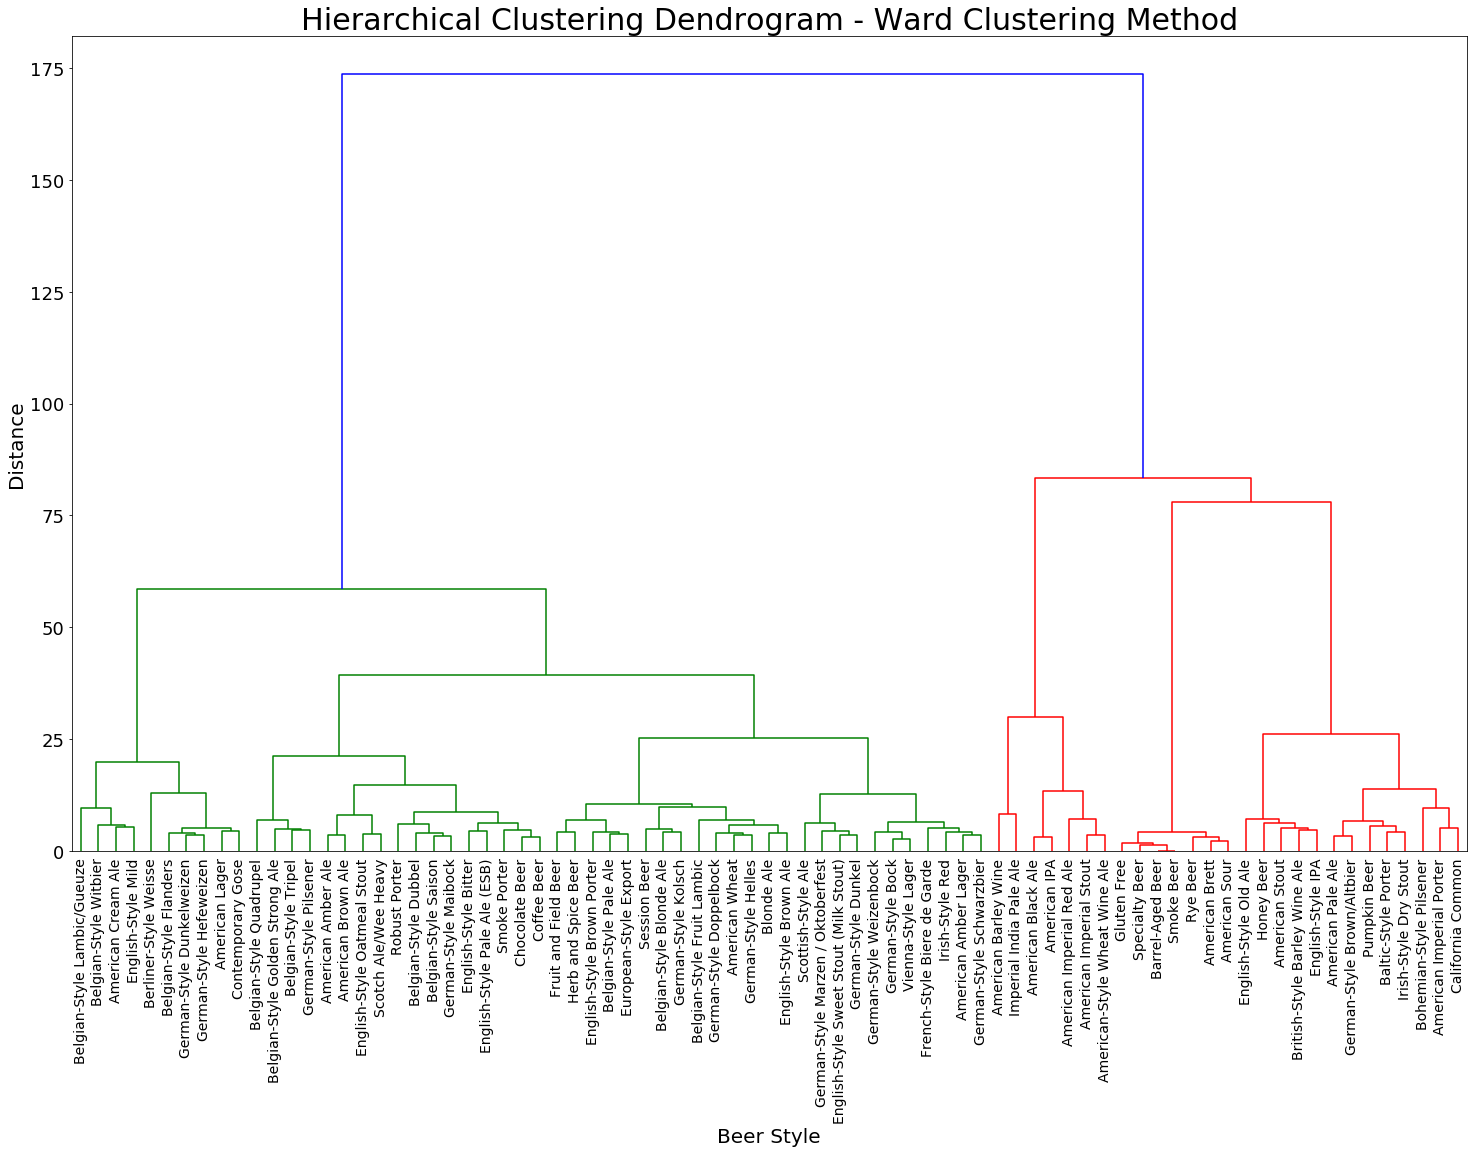

Clustering method: complete
Cophenetic Correlation Coefficient: 0.512


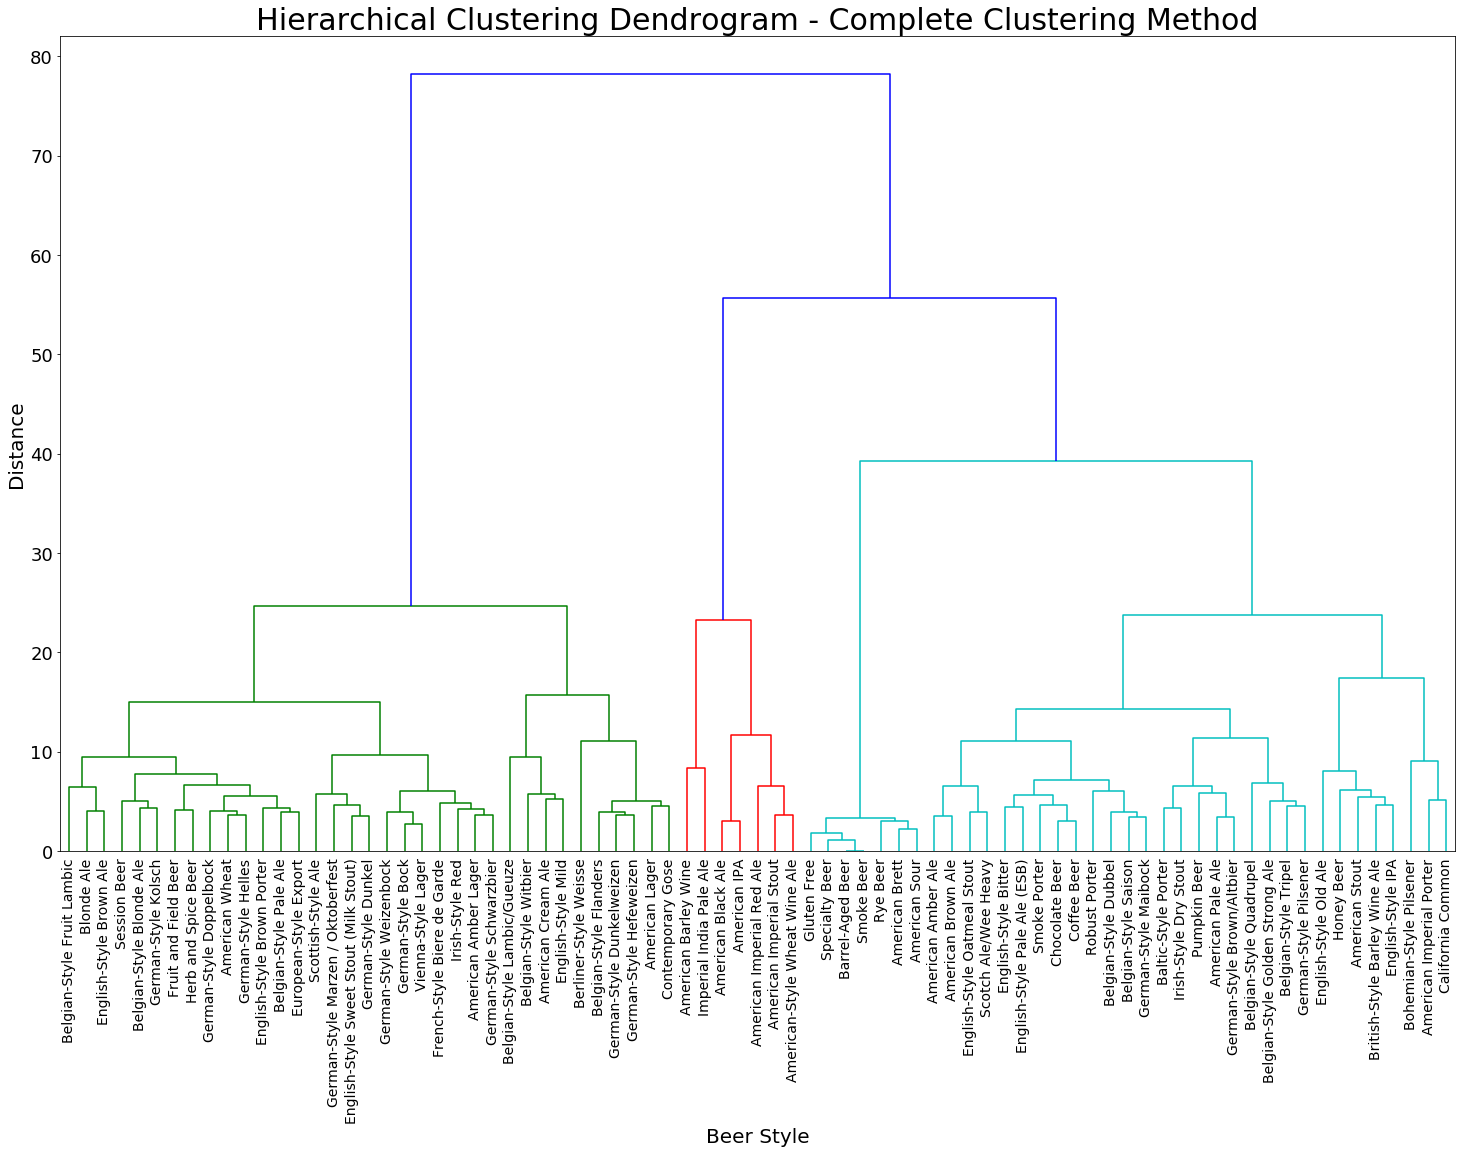

Clustering method: median
Cophenetic Correlation Coefficient: 0.424


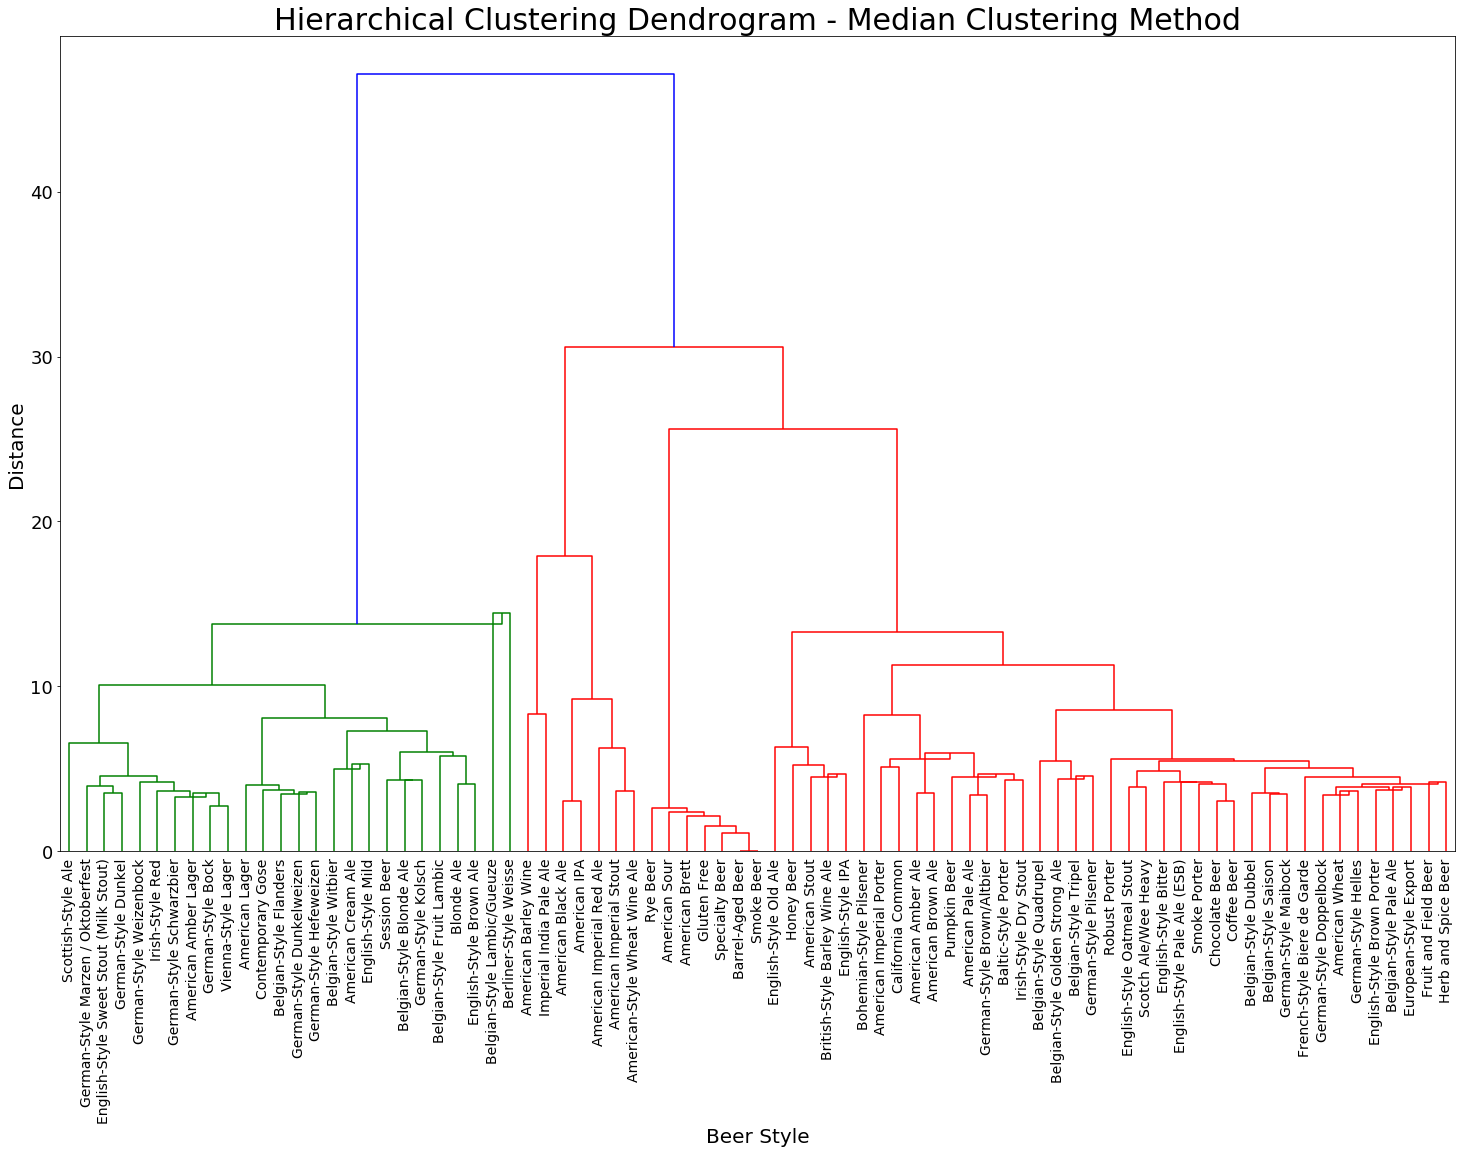

Clustering method: single
Cophenetic Correlation Coefficient: 0.656


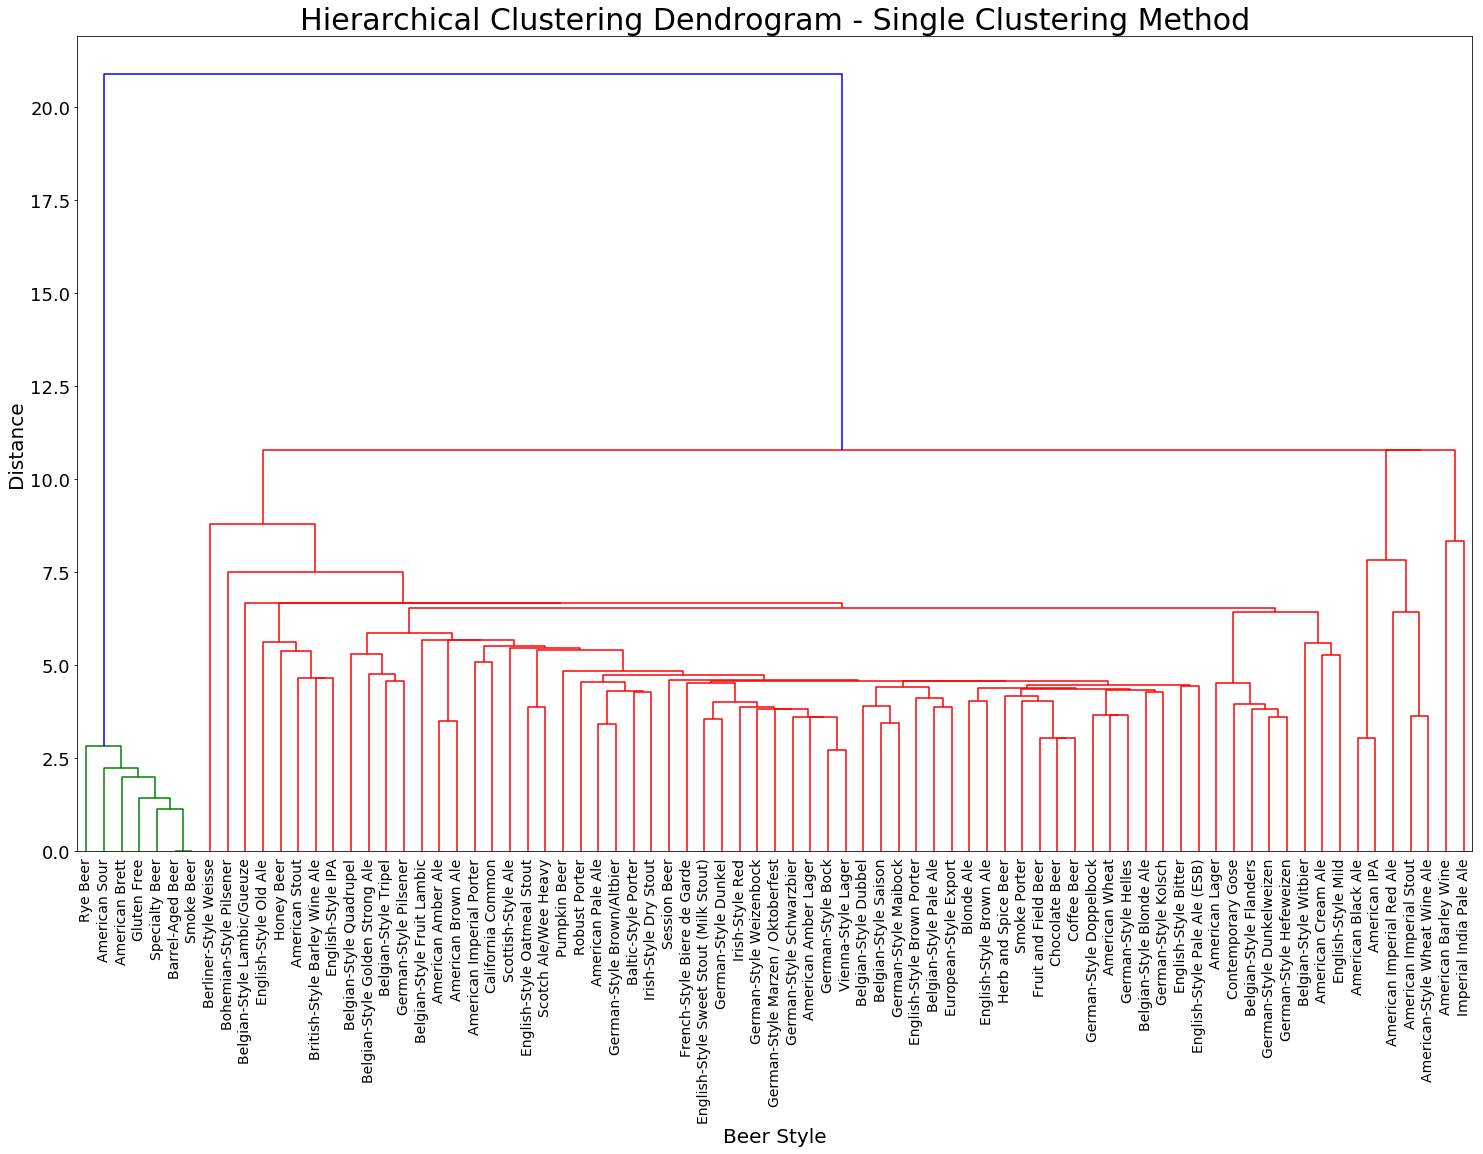

Clustering method: weighted
Cophenetic Correlation Coefficient: 0.784


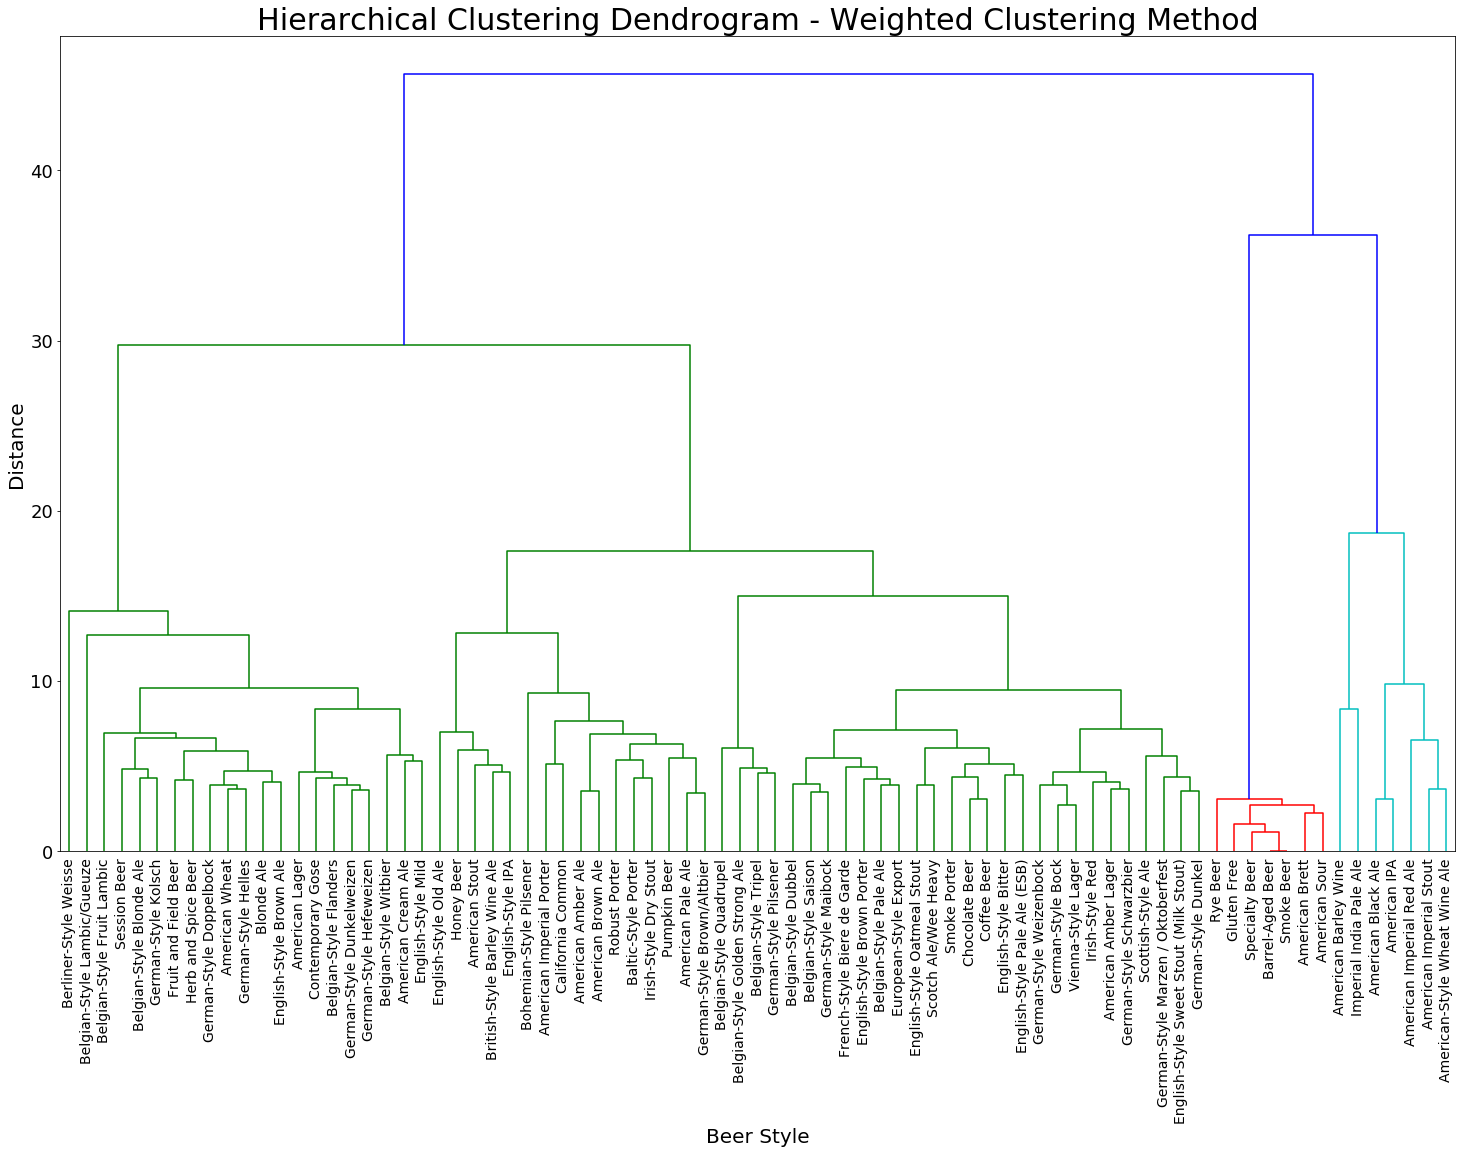

In [22]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

##Hierarchical Clustering and Plot Dendrogram

def cluster(metrics, max_d = None):
    fit = linkage(df, metrics)
    c, coph_dists = cophenet(fit, pdist(df))
    print('Clustering method: {}\nCophenetic Correlation Coefficient: {:.3f}'.format(metrics,c)) 
    
    fig = plt.figure(figsize=(25, 15))
    ax = fig.add_subplot(111)

    dendrogram(fit, leaf_rotation=90., leaf_font_size=8.)
    title = 'Hierarchical Clustering Dendrogram - ' + metrics.capitalize() + ' Clustering Method'
    plt.title(title,fontsize = 30)
    plt.xlabel('Beer Style',fontsize = 20)
    plt.ylabel('Distance',fontsize = 20)
    plt.yticks(fontsize=18)
    plt.plot([0, 10000], [max_d, max_d], 'k--')

    #Change Xticks Labels
    xticks_txt = ' '.join(label.get_text() for label in ax.get_xticklabels()).split(' ')
    xticks_inx = []
    xticks_value = []
    for i in xticks_txt:
        xticks_inx.append(int(i))

    for i in xticks_inx:
        xticks_value.append(df.index.values[i])
    
    ax.set_xticklabels(xticks_value, fontsize = 14)

    plt.show()
    return fit

linkage_metrics = ['average','centroid','ward','complete','median','single','weighted']

for i in range(len(linkage_metrics)):
    cluster(linkage_metrics[i])

Clustering method: average
Cophenetic Correlation Coefficient: 0.82


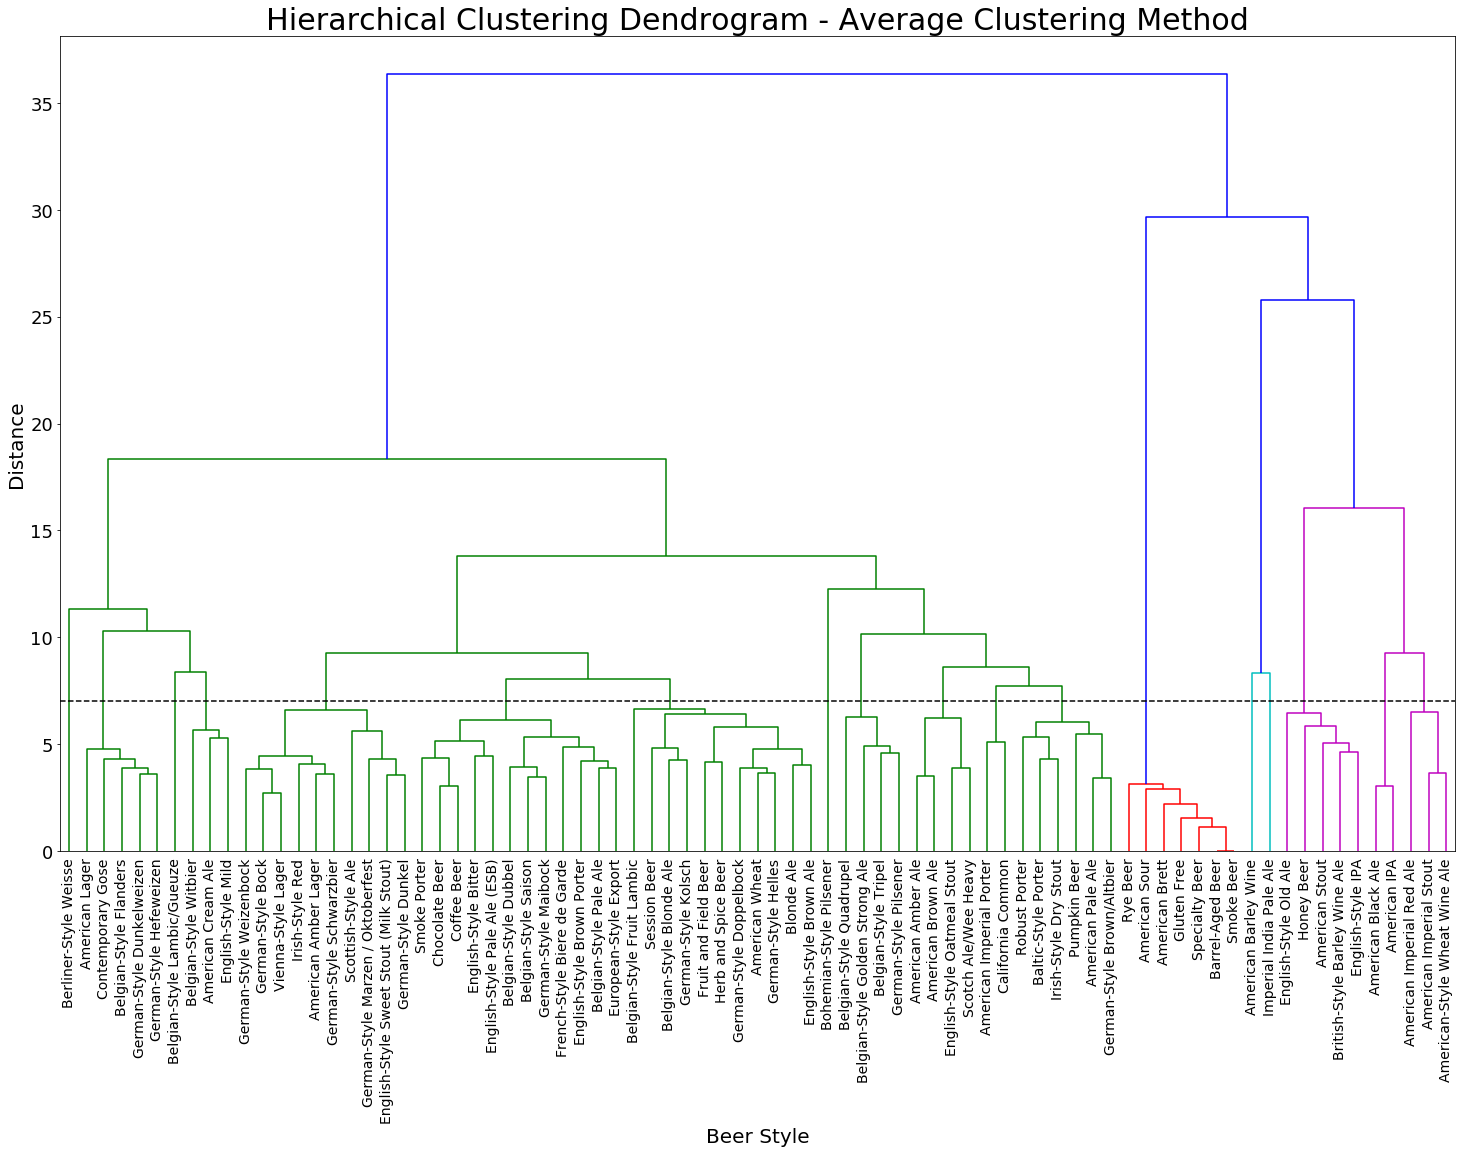

Cluster 1 contains 5 beer styles:
 ['American Lager', 'Belgian-Style Flanders', 'Contemporary Gose', 'German-Style Dunkelweizen', 'German-Style Hefeweizen']

Cluster 2 contains 3 beer styles:
 ['American Cream Ale', 'Belgian-Style Witbier', 'English-Style Mild']

Cluster 3 contains 1 beer styles:
 ['Belgian-Style Lambic/Gueuze']

Cluster 4 contains 1 beer styles:
 ['Berliner-Style Weisse']

Cluster 5 contains 10 beer styles:
 ['American Amber Lager', 'English-Style Sweet Stout (Milk Stout)', 'German-Style Bock', 'German-Style Dunkel', 'German-Style Marzen / Oktoberfest', 'German-Style Schwarzbier', 'German-Style Weizenbock', 'Irish-Style Red', 'Scottish-Style Ale', 'Vienna-Style Lager']

Cluster 6 contains 12 beer styles:
 ['Belgian-Style Dubbel', 'Belgian-Style Pale Ale', 'Belgian-Style Saison', 'Chocolate Beer', 'Coffee Beer', 'English-Style Bitter', 'English-Style Brown Porter', 'English-Style Pale Ale (ESB)', 'European-Style Export', 'French-Style Biere de Garde', 'German-Style Mai

In [21]:
#Retrieve Clusters
max_d = 7 #Can be adjusted

clusters = fcluster(cluster('average', max_d), max_d, criterion='distance')
df_clusters = pd.DataFrame(clusters, columns = ['Cluster'])
clusters_list = []

for i in range(min(clusters),max(clusters)+1):
    for j in np.where(clusters == i):
        print('Cluster {} contains {} beer styles:\n {}\n'.format(i,len(df.index[j].tolist()),df.index[j].tolist()))